## Imports

In [3]:
from skimage import io, img_as_float
import skimage.segmentation as seg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,10]
import PIL
from PIL import Image

### Load Image

In [4]:
img = img_as_float(io.imread('Glacier.tiff'))

## Resize Function

In [5]:
def resize_img(str, width, height):
    img = Image.open(str)
    print('Original Dimensions : ',img.size)
    img2 = img.resize((width, height), PIL.Image.ANTIALIAS)
    print('New Dimensions :', img2.size)
    
    return img2

### Change PIL image to numpy array

In [6]:
def pil_to_ndarray(image, dtype=None, img_num=None):
    """Import a PIL Image object to an ndarray, in memory.
    Parameters
    ----------
    Refer to ``imread``.
    """
    try:
        # this will raise an IOError if the file is not readable
        image.getdata()[0]
    except IOError as e:
        site = "http://pillow.readthedocs.org/en/latest/installation.html#external-libraries"
        pillow_error_message = str(e)
        error_message = ('Could not load "%s" \n'
                         'Reason: "%s"\n'
                         'Please see documentation at: %s'
                         % (image.filename, pillow_error_message, site))
        raise ValueError(error_message)
    frames = []
    grayscale = None
    i = 0
    while 1:
        try:
            image.seek(i)
        except EOFError:
            break

        frame = image

        if img_num is not None and img_num != i:
            image.getdata()[0]
            i += 1
            continue

        if image.format == 'PNG' and image.mode == 'I' and dtype is None:
            dtype = 'uint16'

        if image.mode == 'P':
            if grayscale is None:
                grayscale = _palette_is_grayscale(image)

            if grayscale:
                frame = image.convert('L')
            else:
                if image.format == 'PNG' and 'transparency' in image.info:
                    frame = image.convert('RGBA')
                else:
                    frame = image.convert('RGB')

        elif image.mode == '1':
            frame = image.convert('L')

        elif 'A' in image.mode:
            frame = image.convert('RGBA')

        elif image.mode == 'CMYK':
            frame = image.convert('RGB')

        if image.mode.startswith('I;16'):
            shape = image.size
            dtype = '>u2' if image.mode.endswith('B') else '<u2'
            if 'S' in image.mode:
                dtype = dtype.replace('u', 'i')
            frame = np.fromstring(frame.tobytes(), dtype)
            frame.shape = shape[::-1]

        else:
            frame = np.array(frame, dtype=dtype)

        frames.append(frame)
        i += 1

        if img_num is not None:
            break

    if hasattr(image, 'fp') and image.fp:
        image.fp.close()

    if img_num is None and len(frames) > 1:
        return np.array(frames)
    elif frames:
        return frames[0]
    elif img_num:
        raise IndexError('Could not find image  #%s' % img_num)

Original Dimensions :  (8061, 8751)
New Dimensions : (500, 500)


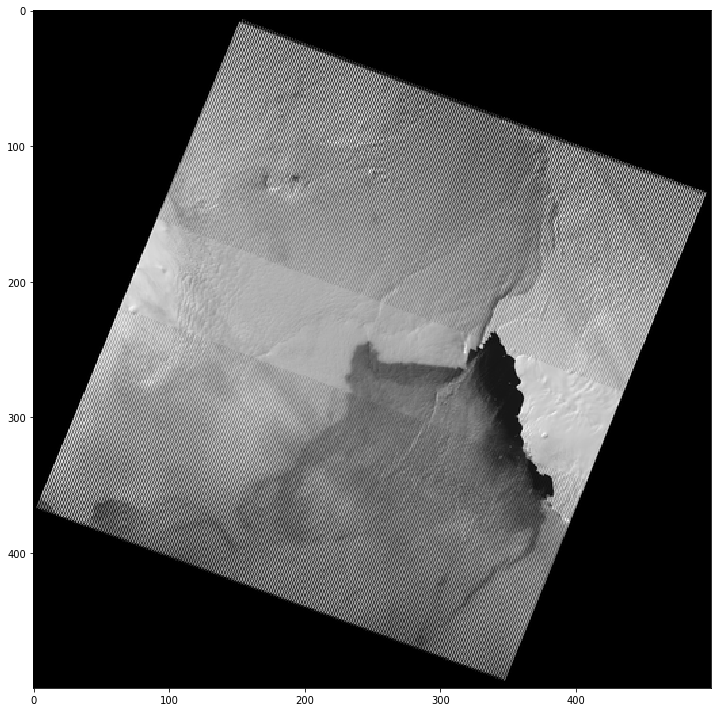

In [7]:
img = resize_img('Glacier.tiff', 500, 500)

npimg = pil_to_ndarray(img)

io.imshow(npimg)

In [8]:
# Check types are correct 

print(type(img),type(npimg))

<class 'PIL.Image.Image'> <class 'numpy.ndarray'>


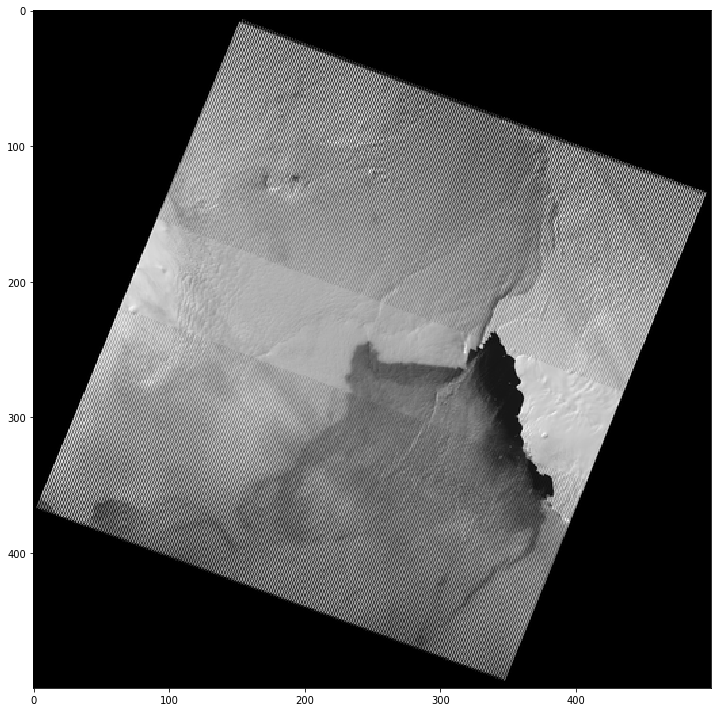

In [9]:
io.imshow(npimg)

(array([108136.,   3756.,  11723.,  18228.,  23169.,  24958.,  33132.,
         20321.,   6395.,    182.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

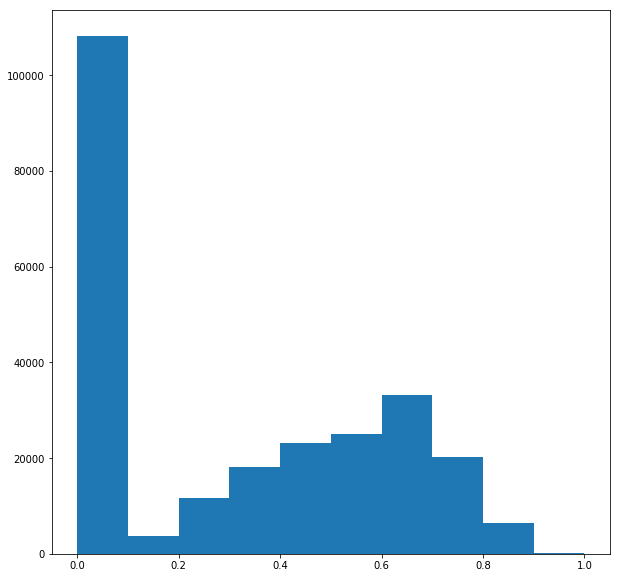

In [10]:
npimg = npimg/255
plt.hist(npimg.flat)

In [11]:
markers = np.zeros(npimg.shape, dtype=np.uint)
markers[(npimg > 0.1) & (npimg < 0.6)] = 1
markers[(npimg > 0.6) & (npimg < 1)] = 2

/Users/zackbarnes/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


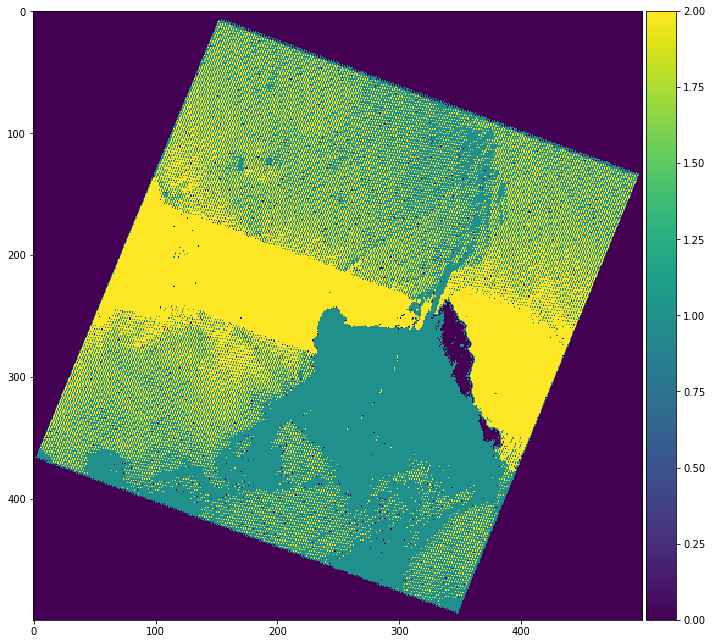

In [22]:
io.imshow(markers)

In [14]:
seg_img = seg.random_walker(npimg, markers, beta = 3000, mode = 'cg_mg')

/Users/zackbarnes/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


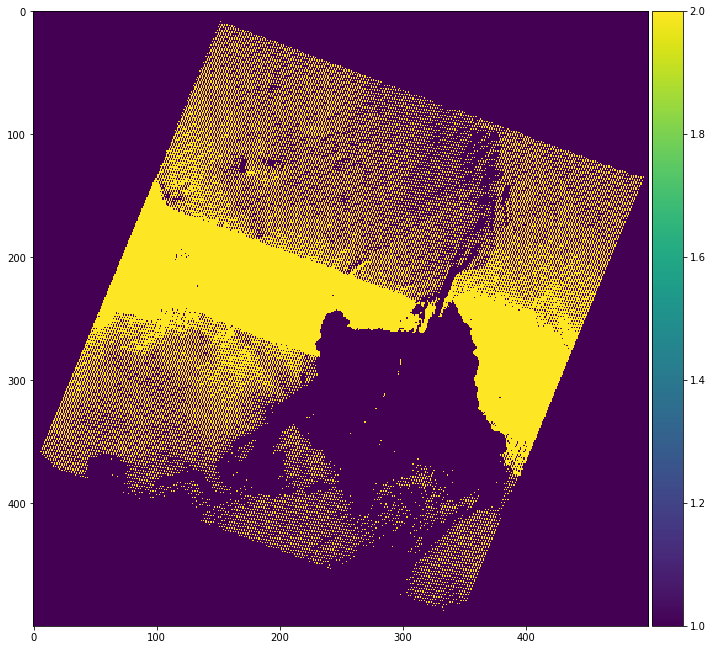

In [15]:
io.imshow(seg_img)

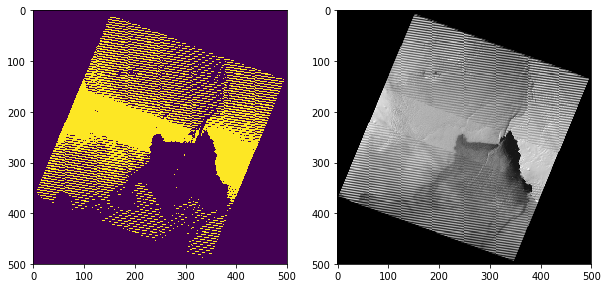

In [16]:
# Two subplots of segmented glacier image on left and original image on right
x = seg_img
y = npimg
f, ax = plt.subplots(1,2)
ax[0].imshow(x)
ax[1].imshow(y,cmap='gray')